# Demand Forecast: ARIMA Model

In [1]:
#import necessary libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import Hyperband
from tensorflow import keras

/var/folders/x4/_l78dvs92m346fbfkb6pl1h40000gn/T/ipykernel_24255/3495411437.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


#### Data Preparation

In [3]:
# Load visitor data
visitor_data = pd.read_csv("../../data/raw/synthetic_visit_data.csv")
visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])
#visitor_data.head()

weather_data = pd.read_csv("../../data/processed/weather_data_cleaned.csv")
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
columns_to_drop = weather_data.columns[0:3].tolist()  # Dropping columns by indices
weather_data.drop(columns=columns_to_drop, inplace=True)
#weather_data.head()

holiday_data = pd.read_csv("../../data/raw/date_info_2324.csv")
holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
holiday_data.drop(columns="day_of_week", inplace=True)
#holiday_data.head()

merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
merged_data.drop(columns=["Date","calender_date","Highest 30 min Rainfall (mm)","Highest 60 min Rainfall (mm)","Highest 120 min Rainfall (mm)","Maximum Temperature (°C)","Minimum Temperature (°C)","Mean Wind Speed (km/h)","Max Wind Speed (km/h)"], inplace=True)
merged_data.head()

,day_of_week,visit_date,visitors,Daily Rainfall Total (mm),Mean Temperature (°C),holiday_flg_sg,holiday_flg_cn,holiday_flg_in
0,Sunday,2023-01-01,409,0.0,27.8,1,1,1
1,Monday,2023-01-02,276,4.0,27.5,1,1,1
2,Tuesday,2023-01-03,158,5.8,27.0,0,0,0
3,Wednesday,2023-01-04,118,0.0,27.1,0,0,0
4,Thursday,2023-01-05,110,38.6,26.4,0,0,0


### ARIMA Model

1. Check for stationarity

In [6]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

check_stationarity(df['visitors'])

ADF Statistic: -4.540648893121904
p-value: 0.00016592835765189215
Series is stationary


2. Plotting ACF and PACF to determine order parameters of ARIMA Model (p,d,q)

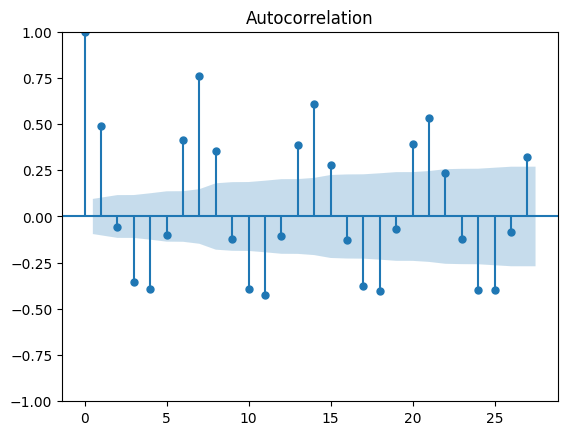

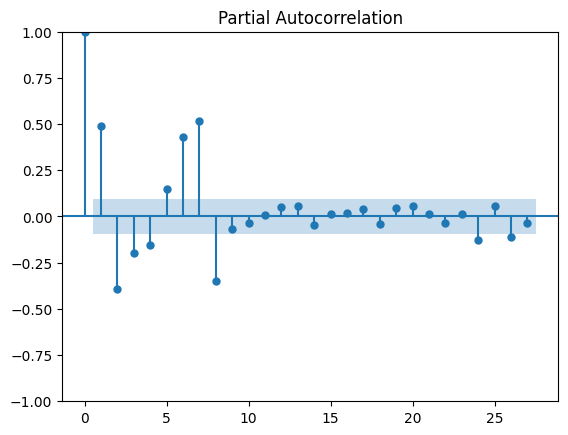

In [8]:
plot_acf(df['visitors'].dropna())
plot_pacf(df['visitors'].dropna())
plt.show()

ACF and PACF Plots: Use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine the potential values for q and p, respectively.

ACF Plot for q: The ACF plot shows the correlation of the series with its lags. In general, you're looking for the point where the ACF plot crosses the upper confidence interval for the first time. This point suggests a good starting value for q.

PACF Plot for p: The PACF plot shows the partial correlation of the series with its lags. You're looking for the point where the PACF plot crosses the upper confidence interval for the first time. This point is a good starting value for p.

From above plot, we shall try q = 1 and p = 1.

3. Model fitting

In [11]:
train_percent = 0.8  # Use 80% of the data for training
split_index = int(len(merged_data) * train_percent)
train_data = visitor_data['visitors'].iloc[:split_index]
test_data = visitor_data['visitors'].iloc[split_index:]
model = ARIMA(train_data, order=(4,1,3))  # p, d, q to be chosen based on your ACF and PACF analysis
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=100)
forecast = pd.Series(forecast, index=test_data.index)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4. Fine-tuning hyperparameters using Grid Search

In [12]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")  # ignore warnings from ARIMA fitting

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(df['visitors'], order=param)
        results = mod.fit()
        
        # Compare current model's AIC with the best so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print('Best ARIMA{} AIC={}'.format(best_pdq, best_aic))

Best ARIMA(4, 1, 3) AIC=4850.800678658924


In [13]:
# Evaluate model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 126.99599003456744
